In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import month, to_date, udf, when, substring, col, count, round
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession


In [2]:
#Building session now
spark = SparkSession.builder.appName('deep_learning_with_spark').getOrCreate()


In [3]:
# Load each CSV file into a separate Spark DataFrame
df1 = spark.read.csv('/mnt/bdpa23-group14-pvc/accidents_2005_to_2007.csv', header=True, inferSchema=True)
df2 = spark.read.csv('/mnt/bdpa23-group14-pvc/accidents_2009_to_2011.csv', header=True, inferSchema=True)
df3 = spark.read.csv('/mnt/bdpa23-group14-pvc/accidents_2012_to_2014.csv', header=True, inferSchema=True)

# Combine the DataFrames into a single DataFrame
predata = df1.union(df2).union(df3)

predata.dtypes

[('Accident_Index', 'string'),
 ('Location_Easting_OSGR', 'int'),
 ('Location_Northing_OSGR', 'int'),
 ('Longitude', 'double'),
 ('Latitude', 'double'),
 ('Police_Force', 'int'),
 ('Accident_Severity', 'int'),
 ('Number_of_Vehicles', 'int'),
 ('Number_of_Casualties', 'int'),
 ('Date', 'string'),
 ('Day_of_Week', 'int'),
 ('Time', 'string'),
 ('Local_Authority_(District)', 'int'),
 ('Local_Authority_(Highway)', 'string'),
 ('1st_Road_Class', 'int'),
 ('1st_Road_Number', 'int'),
 ('Road_Type', 'string'),
 ('Speed_limit', 'int'),
 ('Junction_Detail', 'string'),
 ('Junction_Control', 'string'),
 ('2nd_Road_Class', 'int'),
 ('2nd_Road_Number', 'int'),
 ('Pedestrian_Crossing-Human_Control', 'string'),
 ('Pedestrian_Crossing-Physical_Facilities', 'string'),
 ('Light_Conditions', 'string'),
 ('Weather_Conditions', 'string'),
 ('Road_Surface_Conditions', 'string'),
 ('Special_Conditions_at_Site', 'string'),
 ('Carriageway_Hazards', 'string'),
 ('Urban_or_Rural_Area', 'int'),
 ('Did_Police_Offic

In [15]:
# Data cleaning
columns_to_keep = ["Accident_Severity", "Longitude", "Latitude",
                   "Time", "Date", "Day_of_Week", "Light_Conditions", "Weather_Conditions",
                   "Speed_limit", "Road_Type", "Road_Surface_Conditions"]
data = predata.select(*columns_to_keep)

# Creating "Month" variable from "Date" variable
map_month_udf = udf(lambda month_num: {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}[month_num], StringType())

df = data.withColumn("Month", map_month_udf(month(to_date("Date", "dd/MM/yyyy"))))

# Converting "Day_of_Week" variable to a string
df = df.withColumn('Day_of_Week', when(df['Day_of_Week'] == 1, 'Sunday')
    .when(df['Day_of_Week'] == 2, 'Monday')
    .when(df['Day_of_Week'] == 3, 'Tuesday')
    .when(df['Day_of_Week'] == 4, 'Wednesday')
    .when(df['Day_of_Week'] == 5, 'Thursday')
    .when(df['Day_of_Week'] == 6, 'Friday')
    .when(df['Day_of_Week'] == 7, 'Saturday'))

# Converting "Accident_Severity" variable to a string
df = df.withColumn("Accident_Severity", when(df["Accident_Severity"] == 1, "Fatal") \
    .when(df["Accident_Severity"] == 2, "Serious") \
    .when(df["Accident_Severity"] == 3, "Slight"))

# Creating "Hour" variable from "Time" variable
df = df.withColumn("Hour", substring("Time", 1, 2))

# Filtering None values from the variable
df = df.filter(df.Hour != "None")
df = df.filter(df.Weather_Conditions != "None")
df = df.filter(df.Road_Surface_Conditions != "None")

# Showing the created variables
df.select("Month").show(n=3)
df.select("Day_of_Week").show(n=3)
df.select("Accident_Severity").show(n=3)
df.select("Hour").show(n=3)

+-------+
|  Month|
+-------+
|January|
|January|
|January|
+-------+
only showing top 3 rows

+-----------+
|Day_of_Week|
+-----------+
|    Tuesday|
|  Wednesday|
|   Thursday|
+-----------+
only showing top 3 rows

+-----------------+
|Accident_Severity|
+-----------------+
|          Serious|
|           Slight|
|           Slight|
+-----------------+
only showing top 3 rows

+----+
|Hour|
+----+
|  17|
|  17|
|  00|
+----+
only showing top 3 rows



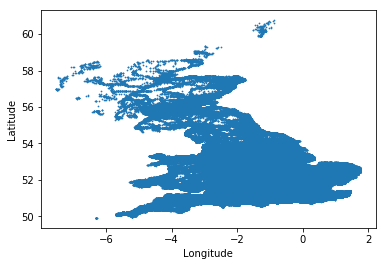

In [7]:
# Plot Data cleaning
columns_to_keep = ["Longitude", "Latitude"]
pldata = predata.select(*columns_to_keep)

dff = pldata.toPandas()

dff["Longitude"] = pd.to_numeric(dff.Longitude,errors='coerce')
dff["Latitude"] = pd.to_numeric(dff.Latitude,errors='coerce')

dff.plot(kind='scatter',x="Longitude",y="Latitude", s=0.5)

In [6]:
def create_heatmap(data, xticks, yticks, cmap="jet", title="Heatmap", xlabel="", ylabel=""):
    """
    Creates a heatmap using the input data and axis labels.

    Args:
        data (pd.DataFrame): The data to use for the heatmap
        xticks (list): The labels for the x-axis ticks
        yticks (list): The labels for the y-axis ticks
        cmap (str): The color map to use (default is "jet")
        title (str): The title of the plot (default is "Heatmap")
        xlabel (str): The label for the x-axis (default is empty string)
        ylabel (str): The label for the y-axis (default is empty string)

    Returns:
        The created heatmap plot.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    heatmap_plot = ax.imshow(data, cmap=cmap)
    ax.set_xticks(range(len(xticks)))
    ax.set_xticklabels(xticks, rotation=90)
    ax.set_yticks(range(len(yticks)))
    ax.set_yticklabels(yticks)

    cbar = ax.figure.colorbar(heatmap_plot, ax=ax)
    cbar.ax.set_ylabel("Number of Accidents", rotation=-90, va="bottom")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    return plt.show()

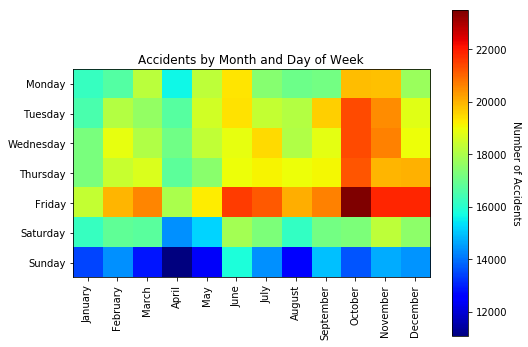

In [16]:
heatmap_data_1 = (df.groupBy("Month")
                .pivot("Day_of_Week")
                .count()
                .orderBy("Month")
                .selectExpr("Month", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
                .na.fill(0))

month_names = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

heatmap_data_pandas_1 = heatmap_data_1.toPandas().set_index("Month").transpose()

create_heatmap(heatmap_data_pandas_1, month_names, heatmap_data_pandas_1.index, title="Accidents by Month and Day of Week", xlabel="", ylabel="")

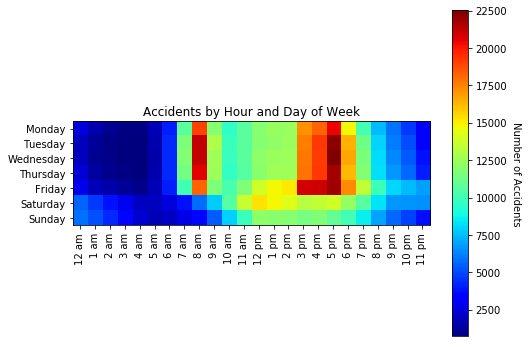

In [15]:
heatmap_data_2 = (df.groupBy("Hour")
                .pivot("Day_of_Week")
                .count()
                .orderBy("Hour")
                .selectExpr("Hour", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
                .na.fill(0))

hour_range = ["12 am", "1 am", "2 am", "3 am", "4 am", "5 am", "6 am", "7 am", "8 am", "9 am", "10 am", "11 am", "12 pm", "1 pm", "2 pm", "3 pm", "4 pm", "5 pm", "6 pm", "7 pm", "8 pm", "9 pm", "10 pm", "11 pm"]

heatmap_data_pandas_2 = heatmap_data_2.toPandas().set_index("Hour").transpose()

create_heatmap(heatmap_data_pandas_2, hour_range, heatmap_data_pandas_2.index, title="Accidents by Hour and Day of Week", xlabel="", ylabel="")

In [6]:
def accident_severity_by_conditions(df, Conditions, order_col=None):
    # Accident severity by conditions
    fatal_accidents = df.filter(df["Accident_Severity"] == "Fatal") \
                        .groupBy(Conditions) \
                        .agg(count("*").alias("Count"))
    
    non_fatal_accidents = df.filter(df["Accident_Severity"] != "Fatal") \
                            .groupBy(Conditions) \
                            .agg(count("*").alias("Count"))
    
    total_accidents = df.count()
    
    # percentage of accidents for each condition
    total_fatal_accidents = fatal_accidents.groupBy().sum("Count").collect()[0][0]
    fatal_accidents = fatal_accidents \
        .withColumn("Fatal_%", round(fatal_accidents["Count"] / total_fatal_accidents * 100, 2)) \
        .withColumn("Total_%", round(fatal_accidents["Count"] / total_accidents * 100, 2))
    
    total_non_fatal_accidents = non_fatal_accidents.groupBy().sum("Count").collect()[0][0]
    non_fatal_accidents = non_fatal_accidents \
        .withColumn("NonFt_%", round(non_fatal_accidents["Count"] / total_non_fatal_accidents * 100, 2)) \
        .withColumn("Total_%", round(non_fatal_accidents["Count"] / total_accidents * 100, 2))
    
    # For speed limit to present data in order from smallest to highest
    if order_col:
        fatal_accidents = fatal_accidents.orderBy(order_col)
        non_fatal_accidents = non_fatal_accidents.orderBy(order_col)
    
    # printing
    print("Fatal accidents")
    fatal_accidents.show(truncate=False)
    print("\nNon-fatal accidents")
    non_fatal_accidents.show(truncate=False)
    
    return fatal_accidents, non_fatal_accidents


# Accident severity by weather conditions

fatal_accidents, non_fatal_accidents = accident_severity_by_conditions(df, "Weather_Conditions")

Fatal accidents
+--------------------------+-----+-------+-------+
|Weather_Conditions        |Count|Fatal_%|Total_%|
+--------------------------+-----+-------+-------+
|Raining without high winds|1854 |9.54   |0.12   |
|Snowing with high winds   |13   |0.07   |0.0    |
|Snowing without high winds|90   |0.46   |0.01   |
|Unknown                   |232  |1.19   |0.02   |
|Other                     |294  |1.51   |0.02   |
|Fine with high winds      |339  |1.75   |0.02   |
|Fine without high winds   |16144|83.11  |1.07   |
|Raining with high winds   |280  |1.44   |0.02   |
|Fog or mist               |179  |0.92   |0.01   |
+--------------------------+-----+-------+-------+


Non-fatal accidents
+--------------------------+-------+-------+-------+
|Weather_Conditions        |Count  |NonFt_%|Total_%|
+--------------------------+-------+-------+-------+
|Raining without high winds|175785 |11.86  |11.7   |
|Snowing with high winds   |1947   |0.13   |0.13   |
|Snowing without high winds|11210 

In [37]:
# Accident severity by light conditions

fatal_accidents, non_fatal_accidents = accident_severity_by_conditions(df, "Light_Conditions")

Fatal accidents
+-----------------------------------------+-----+-------+-------+
|Light_Conditions                         |Count|Fatal_%|Total_%|
+-----------------------------------------+-----+-------+-------+
|Daylight: Street light present           |11456|58.98  |0.76   |
|Darkeness: No street lighting            |3597 |18.52  |0.24   |
|Darkness: Street lights present and lit  |4055 |20.88  |0.27   |
|Darkness: Street lights present but unlit|127  |0.65   |0.01   |
|Darkness: Street lighting unknown        |190  |0.98   |0.01   |
+-----------------------------------------+-----+-------+-------+


Non-fatal accidents
+-----------------------------------------+-------+-------+-------+
|Light_Conditions                         |Count  |NonFt_%|Total_%|
+-----------------------------------------+-------+-------+-------+
|Daylight: Street light present           |1089189|73.47  |72.52  |
|Darkeness: No street lighting            |78882  |5.32   |5.25   |
|Darkness: Street lights pre

In [38]:
# Accident severity by road surface conditions

fatal_accidents, non_fatal_accidents = accident_severity_by_conditions(df, "Road_Surface_Conditions")

Fatal accidents
+-------------------------+-----+-------+-------+
|Road_Surface_Conditions  |Count|Fatal_%|Total_%|
+-------------------------+-----+-------+-------+
|Flood (Over 3cm of water)|41   |0.21   |0.0    |
|Frost/Ice                |326  |1.68   |0.02   |
|Wet/Damp                 |5955 |30.66  |0.4    |
|Dry                      |13029|67.07  |0.87   |
|Snow                     |74   |0.38   |0.0    |
+-------------------------+-----+-------+-------+


Non-fatal accidents
+-------------------------+-------+-------+-------+
|Road_Surface_Conditions  |Count  |NonFt_%|Total_%|
+-------------------------+-------+-------+-------+
|Flood (Over 3cm of water)|2102   |0.14   |0.14   |
|Frost/Ice                |31073  |2.1    |2.07   |
|Wet/Damp                 |417466 |28.16  |27.79  |
|Dry                      |1021468|68.9   |68.01  |
|Snow                     |10423  |0.7    |0.69   |
+-------------------------+-------+-------+-------+



In [9]:
# Accident severity by speed limit

fatal_accidents, non_fatal_accidents = accident_severity_by_conditions(df, "Speed_Limit", "Speed_Limit")


Fatal accidents
+-----------+-----+-------+-------+
|Speed_Limit|Count|Fatal_%|Total_%|
+-----------+-----+-------+-------+
|10         |2    |0.01   |0.0    |
|20         |99   |0.51   |0.01   |
|30         |6490 |33.41  |0.43   |
|40         |1782 |9.17   |0.12   |
|50         |1044 |5.37   |0.07   |
|60         |7472 |38.47  |0.5    |
|70         |2536 |13.06  |0.17   |
+-----------+-----+-------+-------+


Non-fatal accidents
+-----------+------+-------+-------+
|Speed_Limit|Count |NonFt_%|Total_%|
+-----------+------+-------+-------+
|10         |12    |0.0    |0.0    |
|15         |10    |0.0    |0.0    |
|20         |17047 |1.15   |1.13   |
|30         |960328|64.78  |63.94  |
|40         |120448|8.12   |8.02   |
|50         |47703 |3.22   |3.18   |
|60         |230358|15.54  |15.34  |
|70         |106626|7.19   |7.1    |
+-----------+------+-------+-------+



In [7]:
# Accident severity by road type

fatal_accidents, non_fatal_accidents = accident_severity_by_conditions(df, "Road_Type")

Fatal accidents
+------------------+-----+-------+-------+
|Road_Type         |Count|Fatal_%|Total_%|
+------------------+-----+-------+-------+
|Slip road         |127  |0.65   |0.01   |
|One way street    |202  |1.04   |0.01   |
|Unknown           |60   |0.31   |0.0    |
|Roundabout        |307  |1.58   |0.02   |
|Single carriageway|14860|76.5   |0.99   |
|Dual carriageway  |3869 |19.92  |0.26   |
+------------------+-----+-------+-------+


Non-fatal accidents
+------------------+-------+-------+-------+
|Road_Type         |Count  |NonFt_%|Total_%|
+------------------+-------+-------+-------+
|Slip road         |15524  |1.05   |1.03   |
|One way street    |30712  |2.07   |2.04   |
|Unknown           |8262   |0.56   |0.55   |
|Roundabout        |99930  |6.74   |6.65   |
|Single carriageway|1110426|74.9   |73.93  |
|Dual carriageway  |217678 |14.68  |14.49  |
+------------------+-------+-------+-------+



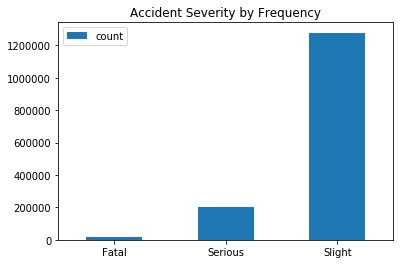

In [5]:
fatal_df = df.filter(df["Accident_Severity"] == "Fatal")
Serious_df = df.filter(df["Accident_Severity"] == "Serious")
Slight_df = df.filter(df["Accident_Severity"] == "Slight")

counts_df = df.groupBy("Accident_Severity").agg(count("*").alias("count"))
counts_pdf = counts_df.toPandas().set_index("Accident_Severity")
counts_pdf = counts_pdf.reindex(["Fatal", "Serious", "Slight"])

# Plot the bar chart
counts_pdf.plot.bar(rot=0)
plt.title("Accident Severity by Frequency")
plt.xlabel("")
plt.ylabel("")
plt.show()

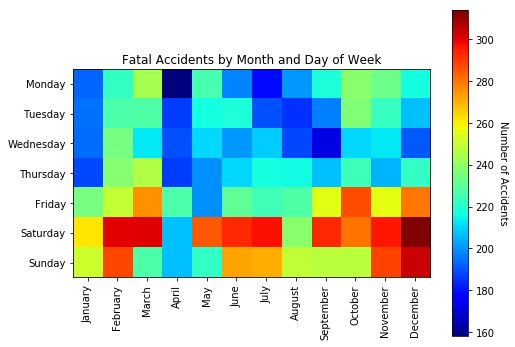

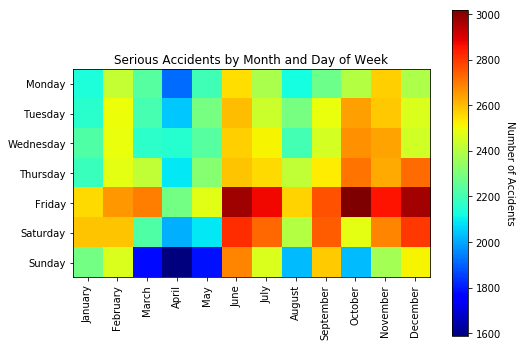

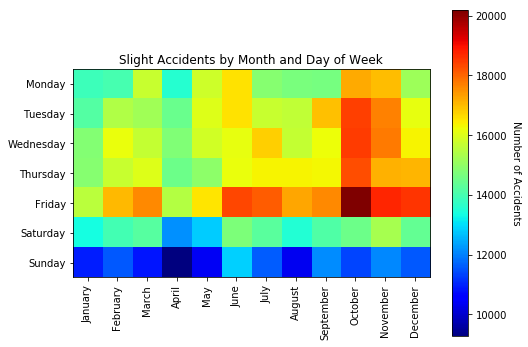

In [18]:
# Fatal Month vs Day of Week
heatmap_data_ft = (fatal_df.groupBy("Month")
                .pivot("Day_of_Week")
                .count()
                .orderBy("Month")
                .selectExpr("Month", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
                .na.fill(0))

heatmap_data_pandas_ft = heatmap_data_ft.toPandas().set_index("Month").transpose()

create_heatmap(heatmap_data_pandas_ft, month_names, heatmap_data_pandas_ft.index, title="Fatal Accidents by Month and Day of Week", xlabel="", ylabel="")

# Serious Month vs Day of Week
heatmap_data_sr = (Serious_df.groupBy("Month")
                .pivot("Day_of_Week")
                .count()
                .orderBy("Month")
                .selectExpr("Month", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
                .na.fill(0))

heatmap_data_pandas_sr = heatmap_data_sr.toPandas().set_index("Month").transpose()

create_heatmap(heatmap_data_pandas_sr, month_names, heatmap_data_pandas_sr.index, title="Serious Accidents by Month and Day of Week", xlabel="", ylabel="")

#Slight Month vs Day of Week
heatmap_data_sl = (Slight_df.groupBy("Month")
                .pivot("Day_of_Week")
                .count()
                .orderBy("Month")
                .selectExpr("Month", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
                .na.fill(0))

heatmap_data_pandas_sl = heatmap_data_sl.toPandas().set_index("Month").transpose()

create_heatmap(heatmap_data_pandas_sl, month_names, heatmap_data_pandas_sl.index, title="Slight Accidents by Month and Day of Week", xlabel="", ylabel="")

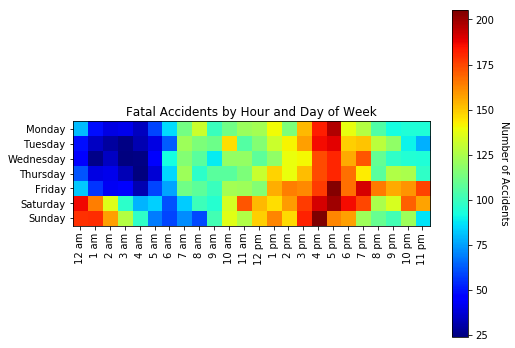

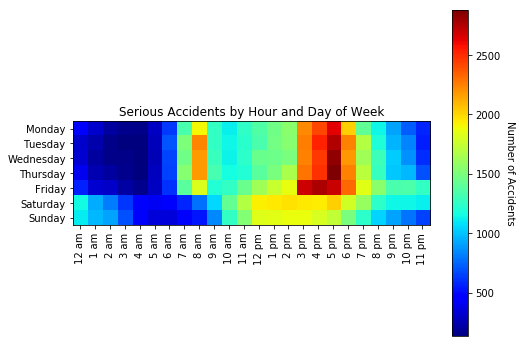

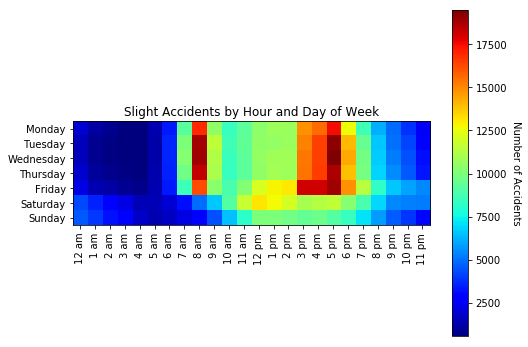

In [19]:
# Fatal Hour vs Day of Week
heatmap_data_ft2 = (fatal_df.groupBy("Hour")
                .pivot("Day_of_Week")
                .count()
                .orderBy("Hour")
                .selectExpr("Hour", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
                .na.fill(0))

hour_range = ["12 am", "1 am", "2 am", "3 am", "4 am", "5 am", "6 am", "7 am", "8 am", "9 am", "10 am", "11 am", "12 pm", "1 pm", "2 pm", "3 pm", "4 pm", "5 pm", "6 pm", "7 pm", "8 pm", "9 pm", "10 pm", "11 pm"]

heatmap_data_ft2_pandas = heatmap_data_ft2.toPandas().set_index("Hour").transpose()

create_heatmap(heatmap_data_ft2_pandas, hour_range, heatmap_data_ft2_pandas.index, title="Fatal Accidents by Hour and Day of Week", xlabel="", ylabel="")

# Serious Hour vs Day of Week
heatmap_data_sr2 = (Serious_df.groupBy("Hour")
                .pivot("Day_of_Week")
                .count()
                .orderBy("Hour")
                .selectExpr("Hour", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
                .na.fill(0))

heatmap_data_sr2_pandas = heatmap_data_sr2.toPandas().set_index("Hour").transpose()

create_heatmap(heatmap_data_sr2_pandas, hour_range, heatmap_data_sr2_pandas.index, title="Serious Accidents by Hour and Day of Week", xlabel="", ylabel="")

# Slight Hour vs Day of Week
heatmap_data_sl2 = (Slight_df.groupBy("Hour")
                .pivot("Day_of_Week")
                .count()
                .orderBy("Hour")
                .selectExpr("Hour", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday")
                .na.fill(0))

heatmap_data_sl2_pandas = heatmap_data_sl2.toPandas().set_index("Hour").transpose()

create_heatmap(heatmap_data_sl2_pandas, hour_range, heatmap_data_sl2_pandas.index, title="Slight Accidents by Hour and Day of Week", xlabel="", ylabel="")

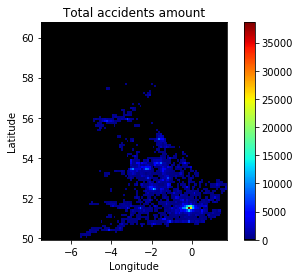

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba

df = predata.select("Longitude", "Latitude")
df = df.dropna(how="any", thresh=None, subset=None)
df = df.toPandas()

# Create a 2D histogram using latitude and longitude as x and y
heatmap, xedges, yedges = np.histogram2d(df["Longitude"], df["Latitude"], bins=100)

# Set the limits of the plot
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Define a new colormap where 0 counts are black and all other counts use the 'jet' colormap
cmap_jet = plt.cm.get_cmap('jet')
cmap_jet_colors = cmap_jet(np.linspace(0, 1, 256))
cmap_jet_colors[0] = (0, 0, 0, 1)  # set the first color to black
cmap_colors = [to_rgba(c) for c in cmap_jet_colors]
cmap = ListedColormap(cmap_colors, name='custom_jet')

# Plot the heatmap using the custom colormap
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cmap)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Total accidents amount')
plt.colorbar()
plt.show()


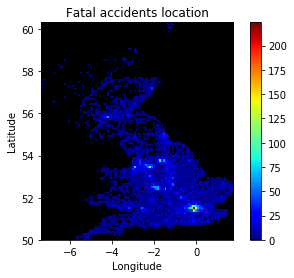

In [12]:
fatal_df = df.filter(df["Accident_Severity"] == "Fatal")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba

df = fatal_df.select("Longitude", "Latitude")
df = df.dropna(how="any", thresh=None, subset=None)
df = df.toPandas()

# Create a 2D histogram using latitude and longitude as x and y
heatmap, xedges, yedges = np.histogram2d(df["Longitude"], df["Latitude"], bins=100)

# Set the limits of the plot
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Define a new colormap where 0 counts are black and all other counts use the 'jet' colormap
cmap_jet = plt.cm.get_cmap('jet')
cmap_jet_colors = cmap_jet(np.linspace(0, 1, 256))
cmap_jet_colors[0] = (0, 0, 0, 1)  # set the first color to black
cmap_colors = [to_rgba(c) for c in cmap_jet_colors]
cmap = ListedColormap(cmap_colors, name='custom_jet')

# Plot the heatmap using the custom colormap
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cmap)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fatal accidents location')
plt.colorbar()
plt.show()

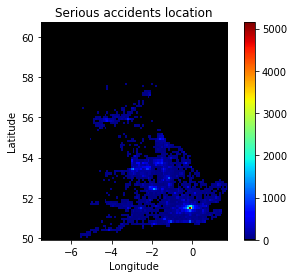

In [16]:
Serious_df = df.filter(df["Accident_Severity"] == "Serious")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba

dfh = Serious_df.select("Longitude", "Latitude")
dfh = dfh.dropna(how="any", thresh=None, subset=None)
dfh = dfh.toPandas()

# Create a 2D histogram using latitude and longitude as x and y
heatmap, xedges, yedges = np.histogram2d(dfh["Longitude"], dfh["Latitude"], bins=100)

# Set the limits of the plot
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Define a new colormap where 0 counts are black and all other counts use the 'jet' colormap
cmap_jet = plt.cm.get_cmap('jet')
cmap_jet_colors = cmap_jet(np.linspace(0, 1, 256))
cmap_jet_colors[0] = (0, 0, 0, 1)  # set the first color to black
cmap_colors = [to_rgba(c) for c in cmap_jet_colors]
cmap = ListedColormap(cmap_colors, name='custom_jet')

# Plot the heatmap using the custom colormap
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cmap)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Serious accidents location')
plt.colorbar()
plt.show()

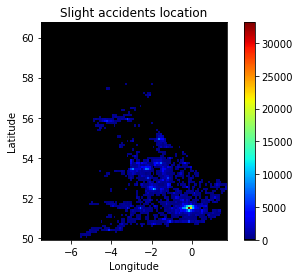

In [18]:
Slight_df = df.filter(df["Accident_Severity"] == "Slight")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgba

dfh = Slight_df.select("Longitude", "Latitude")
dfh = dfh.dropna(how="any", thresh=None, subset=None)
dfh = dfh.toPandas()

# Create a 2D histogram using latitude and longitude as x and y
heatmap, xedges, yedges = np.histogram2d(dfh["Longitude"], dfh["Latitude"], bins=100)

# Set the limits of the plot
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Define a new colormap where 0 counts are black and all other counts use the 'jet' colormap
cmap_jet = plt.cm.get_cmap('jet')
cmap_jet_colors = cmap_jet(np.linspace(0, 1, 256))
cmap_jet_colors[0] = (0, 0, 0, 1)  # set the first color to black
cmap_colors = [to_rgba(c) for c in cmap_jet_colors]
cmap = ListedColormap(cmap_colors, name='custom_jet')

# Plot the heatmap using the custom colormap
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', cmap=cmap)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Slight accidents location')
plt.colorbar()
plt.show()